# Class Activation Mapping (CAM)

The class activation mapping (CAM) method produces an attribution map from any convolutional layer of the image classification model. We use cam on the final convolutional layer as it provides the best results. Unlike the gradient methods, CAM places strict requirements on the models. CAM's requirements are listed below: 
- The classification model needs to have convolutional layers.
- The model mustn't have fully connected layers (dense layers).
- It requires a global average pooling (GAP) layer as the last layer before the softmax layer.

Unfortunately replacing the fully connected layers with a GAP layer makes training very slow. I worked around this issue by using the fully connected layers during training. Then when extracting the attribution map I will access the intermediate convolutional layer using Flax's sow method. Then GAP is added to the convolutional layer. This ensures fast training time while satisfying all CAM's requirements.  

For more technical information on the class activation mapping method see: [Learning Deep Features for Discriminative Localization](https://arxiv.org/abs/1512.04150)


In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp
import flax.linen as nn
import jax
from jax import random
from jax import grad
import optax

import requests
import zipfile

### Load training data
Check if the training data exists. If not, automatically download it.

In [8]:
data_dir = os.path.abspath("./digit-recognizer/datasets")
os.makedirs(data_dir, exist_ok=True)
train_data_path = f"{data_dir}/train.zip"
train_data_url = "https://huggingface.co/datasets/ChristianOrr/mnist/resolve/main/train.zip"

def download_file(url, dest_path):
    response = requests.get(url, stream=True)
    response.raise_for_status()
    with open(dest_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

# Download the training data if it doesn't already exist
if not os.path.exists(train_data_path):
    print("Downloading training data...")
    download_file(train_data_url, train_data_path)

# Extract the zip file
with zipfile.ZipFile(train_data_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

data_df = pd.read_csv('./digit-recognizer/datasets/train.csv')

In [9]:
val_size = 1000
# Only shuffle training data
np.random.shuffle(data_df[val_size:].values)
m, n = data_df.shape
Y = jnp.array(data_df["label"])
data_df = data_df.drop("label", axis=1)
X = jnp.array(data_df)


X_train = X[val_size:]
X_train = X_train / 255.
Y_train = Y[val_size:]

X_val = X[:val_size]
X_val = X_val / 255.
Y_val = Y[:val_size]

### Define the classification model

In [10]:
class _forward_fn(nn.Module):

    @nn.compact
    def __call__(self, x):
        batch_size = x.shape[0]
        # Unflatten for the convolution layers
        x = x.reshape(batch_size, 28, 28, 1)
        conv_layers = nn.Sequential([
            nn.Conv(features=16, kernel_size=(3, 3), padding="VALID", use_bias=False), jax.nn.relu,
            nn.Conv(features=32, kernel_size=(3, 3), padding="VALID", use_bias=False), jax.nn.relu,  
        ])
        x = conv_layers(x)
        # Save the final convolution layer as an intermediate so 
        # it can be accessed for the cam algorithm
        self.sow("intermediates", "final_conv_layer", x)

        x = x.reshape((batch_size, -1))
        x = nn.Dense(10)(x)
        return jax.nn.softmax(x)

# Create the model object
forward_fn = _forward_fn()
# Display the model details
dummy_x = X_train[:5]
rng_key = random.PRNGKey(64)
initial_params = forward_fn.init(rng_key, dummy_x)
print(forward_fn.tabulate(rng_key, dummy_x))


                              _forward_fn Summary                               
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path         ┃ module      ┃ inputs         ┃ outputs       ┃ params         ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│              │ _forward_fn │ float32[5,784] │ float32[5,10] │                │
├──────────────┼─────────────┼────────────────┼───────────────┼────────────────┤
│ Sequential_0 │ Sequential  │ float32[5,28,… │ float32[5,24… │                │
├──────────────┼─────────────┼────────────────┼───────────────┼────────────────┤
│ Conv_0       │ Conv        │ float32[5,28,… │ float32[5,26… │ kernel:        │
│              │             │                │               │ float32[3,3,1… │
│              │             │                │               │                │
│              │             │                │               │ 144 (576 B)    │
├──────────────┼───────────

### Define the loss function and update method

In [11]:
def loss_fn(params, X, Y):
    logits = forward_fn.apply(params, X)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, Y)
    loss = loss.mean()
    return loss

def update_params(params, opt_state, X, Y, optimizer):
    grads = grad(loss_fn, argnums=0)(params, X, Y)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state

### Train the model

In [12]:
def get_predictions(logits):
    return jnp.argmax(logits, axis=1)

def get_accuracy(predictions, Y):
    return jnp.mean(predictions == Y)

def gradient_descent(X, Y, batch_size, optimizer, epochs):
    dataset_size = len(X)
    steps_per_epoch = dataset_size // batch_size

    rng = jax.random.PRNGKey(42)
    params = forward_fn.init(rng, X[0: batch_size, :])
    opt_state = optimizer.init(params)
    for epoch in range(epochs):
        dataset_step = epoch % steps_per_epoch
        dataset_index = dataset_step * batch_size
        input = X[dataset_index: dataset_index + batch_size, :]
        label = Y[dataset_index: dataset_index + batch_size, ...]

        params, opt_state = update_params(params, opt_state, input, label, optimizer)
        if epoch % 10 == 0:
            print("Epochs: ", epoch)
            logits = forward_fn.apply(params, input)
            predictions = get_predictions(logits)
            print(get_accuracy(predictions, label))
    return params

In [13]:
optimizer = optax.adam(learning_rate=0.001)

params = gradient_descent(X_train, Y_train, 1000, optimizer, 200)

Epochs:  0
0.53400004
Epochs:  10
0.786
Epochs:  20
0.87500006
Epochs:  30
0.90200007
Epochs:  40
0.90700006
Epochs:  50
0.92700005
Epochs:  60
0.92300004
Epochs:  70
0.938
Epochs:  80
0.95500004
Epochs:  90
0.94200003
Epochs:  100
0.96400005
Epochs:  110
0.96900004
Epochs:  120
0.966
Epochs:  130
0.9710001
Epochs:  140
0.96700007
Epochs:  150
0.9710001
Epochs:  160
0.97200006
Epochs:  170
0.97300005
Epochs:  180
0.97300005
Epochs:  190
0.97800004


### Display predictions and attribution maps

CAM can be performed on any of the convolutional layers. For this demonstration we use the final convolutional layer. To access the convolutional layer it needs to be stored as an intermediate variable in the model definition, then the "mutable='intermediates'" argument is supplied to the model when performing the forward pass. Global average pooling is then applied to the convolutional layer. This is performed by taking the mean of each filter/feature map, this results in a vector of floats with the size of the number of feature maps. The vector is then used as weights for the feature maps. The dot product is taken between the weights and feature maps to provide us with the class activation mapping. 

In [14]:
def make_predictions(X, params):
    logits, state = forward_fn.apply(params, X, mutable='intermediates')
    predictions = get_predictions(logits)
    return predictions, state

def prep_image(image):
    # Normalize the gradient values to be between 0-1
    max_val= np.max(image)
    min_val = np.min(image)
    image = (image - min_val) / (max_val - min_val)
    # Convert the grads to uint8 for displaying
    image = np.uint8(image * 255)
    return image   

def display_prediction(index, params):
    current_image = X_val[None, index]
    prediction, state = make_predictions(X_val[None, index], params)

    label = Y_val[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    display_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(display_image, interpolation='nearest')
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    
    final_conv_layer = state["intermediates"]["final_conv_layer"][0][0]
    # Get weights using global average pooling
    weights = jnp.mean(final_conv_layer, axis=(0, 1))
    # Get the weighted sum of all the filters
    cam = jnp.dot(final_conv_layer, weights)
    cam = prep_image(cam)

    plt.gray()
    plt.imshow(cam, interpolation='nearest')
    plt.axis('off')
    plt.title("Attribution Map")
    plt.show()

Prediction:  [1]
Label:  1


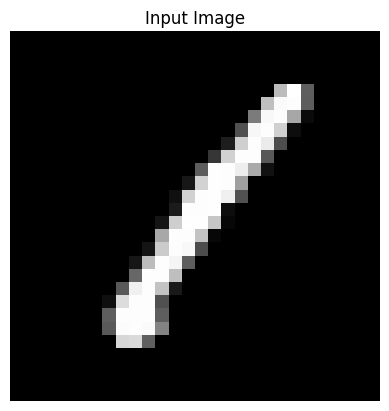

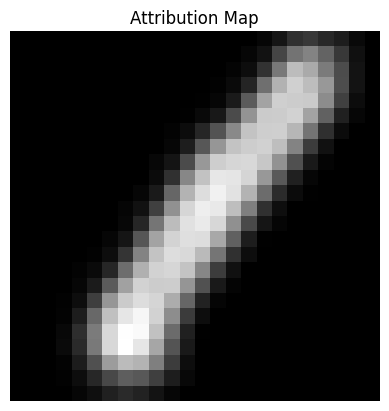

Prediction:  [4]
Label:  4


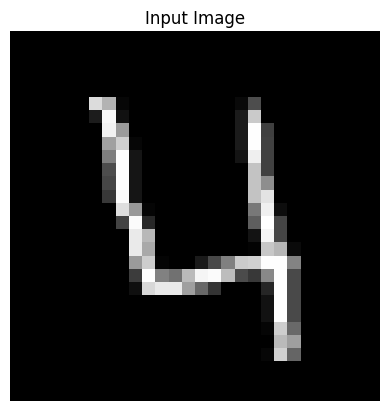

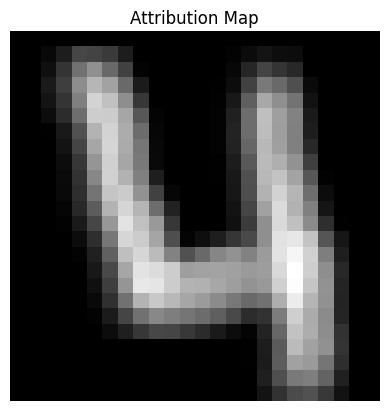

Prediction:  [0]
Label:  0


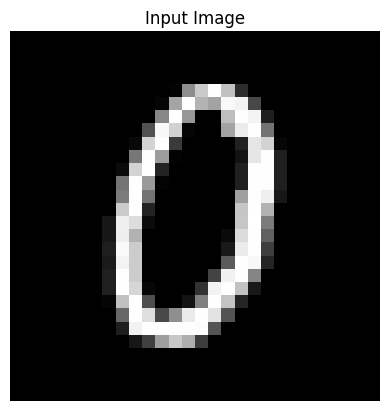

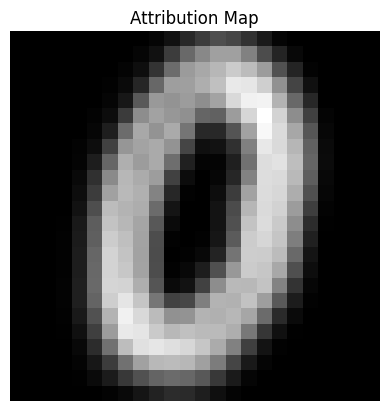

Prediction:  [5]
Label:  5


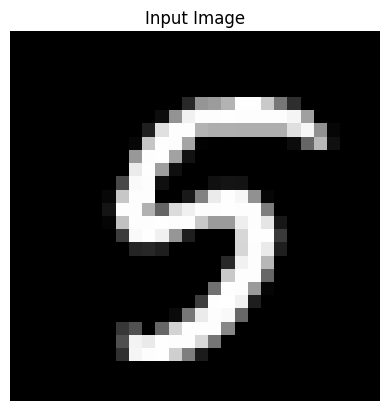

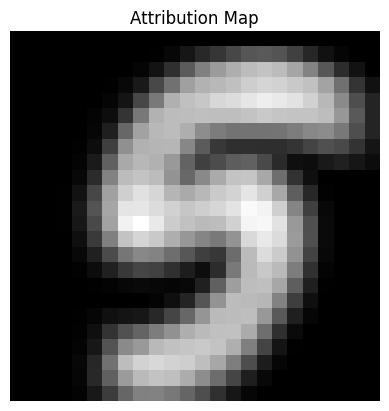

Prediction:  [8]
Label:  8


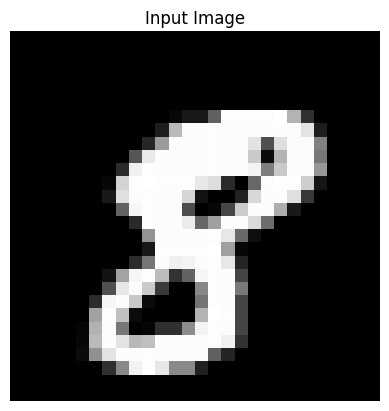

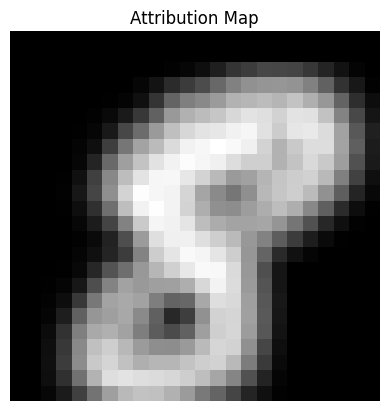

Prediction:  [7]
Label:  7


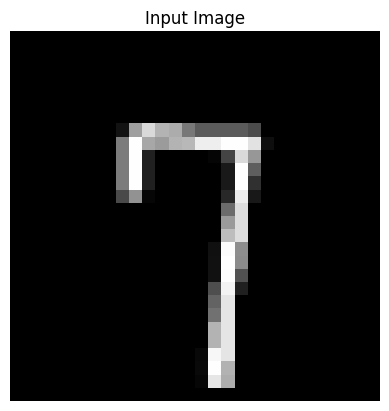

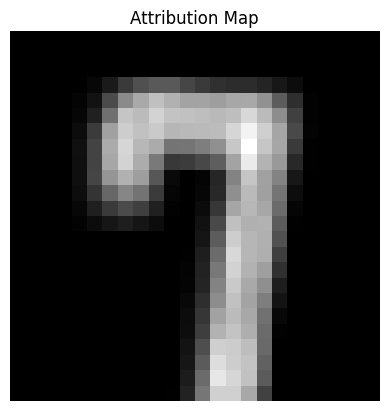

In [15]:
display_prediction(0, params)
display_prediction(3, params)
display_prediction(5, params)
display_prediction(8, params)
display_prediction(10, params)
display_prediction(50, params)